<a href="https://colab.research.google.com/github/faizanfaiz11422/PINNverse/blob/main/3rd-Order-NonLinear-System/3rd_order_system_PINNS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 📦 Step 1: Import Libraries
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

print(f"TensorFlow Version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

TensorFlow Version: 2.19.0
GPU Available: []


In [2]:
# ⚙️ Step 2: Define Physical Parameters
# Based on the user's provided values and mapping to equation variables
De = 4.0      # Deborah Number (from Da)
D = 1.5
R = 1.0       # Thermal Radiation Parameter
S = 3.3       # Heat Source/Sink Parameter
Pr = 1.0      # Prandtl Number
theta1 = 10.0 # Constant (from lambda[1])
theta5 = 10.0 # Constant (from lambda[5])
theta6 = 1.5  # Constant (from lambda[6])
theta9 = 2.0  # Constant (from lambda[9])
theta10 = 10.0 # Constant (from lambda[10])
lambda_data = 10.0 # Weighting factor for data loss to improve compatibility

In [3]:
# 🧠 Step 3: Build PINN Model
# Keeping the same architecture as requested
def build_model():
    inputs = tf.keras.Input(shape=(1,), name="eta")
    x = tf.keras.layers.Dense(32, activation="tanh")(inputs)
    x = tf.keras.layers.Dense(64, activation="relu")(x)
    x = tf.keras.layers.Dense(128, activation="tanh")(x)
    f_out = tf.keras.layers.Dense(1, name="f")(x)
    theta_out = tf.keras.layers.Dense(1, name="theta")(x)
    return tf.keras.Model(inputs=inputs, outputs=[f_out, theta_out])

model = build_model()
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ eta (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │         64 │ eta[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      2,112 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │      8,320 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ f (Dense)           │ (None, 1)         │        129 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ theta (Dense)       │ (None, 1)         │        129 │ dense_2[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 10,754 (42.01 KB)

 Trainable params: 10,754 (42.01 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
# 📉 Step 4: Loss Function
@tf.function
def compute_loss(eta, analytic_eta, analytic_theta):
    # Use a single persistent tape for all derivatives, both for physics and BCs
    with tf.GradientTape(persistent=True) as tape:
        tape.watch(eta)

        # Get model outputs at all necessary points
        f, theta = model(eta)

        # Physics derivatives
        f1 = tape.gradient(f, eta)
        theta1_grad = tape.gradient(theta, eta)
        f2 = tape.gradient(f1, eta)
        theta2_grad = tape.gradient(theta1_grad, eta)
        f3 = tape.gradient(f2, eta)

    del tape

    # Physics residuals based on the new equations
    # R1: f'''+f'²-ff''-De(f'²f'''-2ff'f'') + Df' = 0
    R1 = f3 + f1**2 - f*f2 - De*(f1**2*f3 - 2*f*f1*f2) + D*f1

    # R2: (1+R)/Pr*theta'' + theta9/theta10*f'theta + S(theta6*theta9/theta1*theta10 - theta5/theta1)*theta - f*theta' = 0
    R2 = ((1 + R) / Pr) * theta2_grad + (theta9 / theta10) * f1 * theta + S * ((theta6 * theta9) / (theta1 * theta10) - (theta5 / theta1)) * theta - f * theta1_grad

    physics_loss = tf.reduce_mean(tf.square(R1)) + tf.reduce_mean(tf.square(R2))

    # Boundary conditions loss
    eta_0 = tf.constant([[0.0]], dtype=tf.float32)
    eta_1 = tf.constant([[1.0]], dtype=tf.float32)

    with tf.GradientTape(persistent=True) as tape_bc:
        tape_bc.watch(eta_0)
        tape_bc.watch(eta_1)
        f_at_0, theta_at_0 = model(eta_0)
        f_at_1, theta_at_1 = model(eta_1)
        f1_at_0 = tape_bc.gradient(f_at_0, eta_0)
        f1_at_1 = tape_bc.gradient(f_at_1, eta_1)
        f2_at_1 = tape_bc.gradient(f1_at_1, eta_1)
        theta1_at_1 = tape_bc.gradient(theta_at_1, eta_1)
    del tape_bc

    bc_loss = (tf.square(f_at_0) +        # f(0) = 0
               tf.square(f1_at_0 - 1.0) + # f'(0) = 1
               tf.square(theta_at_0 - 1.0) +  # theta(0) = 1
               tf.square(f_at_1) +        # f(1) = 0
               tf.square(f2_at_1) +       # f''(1) = 0
               tf.square(theta1_at_1))    # theta'(1) = 0

    # Data loss, comparing model prediction with provided analytical data
    _, theta_pred_at_analytic = model(analytic_eta)
    data_loss = tf.reduce_mean(tf.square(theta_pred_at_analytic - analytic_theta))

    return physics_loss, bc_loss, data_loss, theta_pred_at_analytic


In [5]:
# 🏋️ Step 5: Training Loop
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
EPOCHS = 1500 # Increased epochs for better convergence on complex problem
loss_history = []
r2_history = []

# Training domain is now from 0.0 to 1.0
train_eta = tf.random.uniform((500, 1), minval=0.0, maxval=1.0)

# 📂 Load Analytic Solution
try:
    data = pd.read_csv("mydata1.csv", header=None)
    analytic_eta = tf.constant(data.iloc[:, 0].values.reshape(-1, 1), dtype=tf.float32)
    analytic_theta = tf.constant(data.iloc[:, 1].values.reshape(-1, 1), dtype=tf.float32)
    print("✅ Analytic data loaded successfully.")
except Exception as e:
    print(f"❌ Error loading CSV: {e}")
    analytic_eta = tf.constant([], dtype=tf.float32)
    analytic_theta = tf.constant([], dtype=tf.float32)

for epoch in range(EPOCHS):
    with tf.GradientTape() as tape:
        # Corrected this line to unpack all four returned values
        physics_loss, bc_loss, data_loss, theta_pred_at_analytic = compute_loss(train_eta, analytic_eta, analytic_theta)
        # Use lambda_data to weight the data loss
        total_loss = physics_loss + bc_loss + lambda_data * data_loss
    grads = tape.gradient(total_loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Store loss and R2 for plotting later
    loss_history.append(total_loss.numpy().item())

    # Calculate R-squared during training
    if not analytic_eta.numpy().size == 0:
      ss_total = tf.reduce_sum(tf.square(analytic_theta - tf.reduce_mean(analytic_theta)))
      ss_residual = tf.reduce_sum(tf.square(analytic_theta - theta_pred_at_analytic))
      r2 = 1 - ss_residual / ss_total
      r2_history.append(r2.numpy().item())
    else:
      r2_history.append(np.nan) # Append NaN if data is not available

    if epoch % 10 == 0:
        if not analytic_eta.numpy().size == 0:
            print(f"Epoch {epoch}: Total Loss = {total_loss.numpy().item():.6f}, "
                  f"Physics = {physics_loss.numpy().item():.6f}, BC = {bc_loss.numpy().item():.6f}, "
                  f"Data = {data_loss.numpy().item():.6f}, R² = {r2:.6f}")
        else:
            print(f"Epoch {epoch}: Total Loss = {total_loss.numpy().item():.6f}, "
                  f"Physics = {physics_loss.numpy().item():.6f}, BC = {bc_loss.numpy().item():.6f}, "
                  f"Data = {data_loss.numpy().item():.6f}")

✅ Analytic data loaded successfully.


Epoch 0: Total Loss = 7.108371, Physics = 0.035017, BC = 2.012999, Data = 0.506036, R² = -23.166283
Epoch 10: Total Loss = 4.253341, Physics = 1.556595, BC = 1.073258, Data = 0.162349, R² = -6.753146
Epoch 20: Total Loss = 3.292546, Physics = 0.743176, BC = 0.658437, Data = 0.189093, R² = -8.030358
Epoch 30: Total Loss = 2.930789, Physics = 1.582228, BC = 0.396505, Data = 0.095206, R² = -3.546643
Epoch 40: Total Loss = 2.742780, Physics = 1.275889, BC = 0.378317, Data = 0.108857, R² = -4.198603
Epoch 50: Total Loss = 2.584521, Physics = 1.387800, BC = 0.370415, Data = 0.082631, R² = -2.946111
Epoch 60: Total Loss = 2.441010, Physics = 1.180236, BC = 0.415659, Data = 0.084511, R² = -3.035933
Epoch 70: Total Loss = 2.234155, Physics = 1.048575, BC = 0.387140, Data = 0.079844, R² = -2.813040
Epoch 80: Total Loss = 1.973350, Physics = 0.934069, BC = 0.364456, Data = 0.067483, R² = -2.222704
Epoch 90: Total Loss = 1.747590, Physics = 0.846303, BC = 0.379396, Data = 0.052189, R² = -1.492349


✅ Training complete!


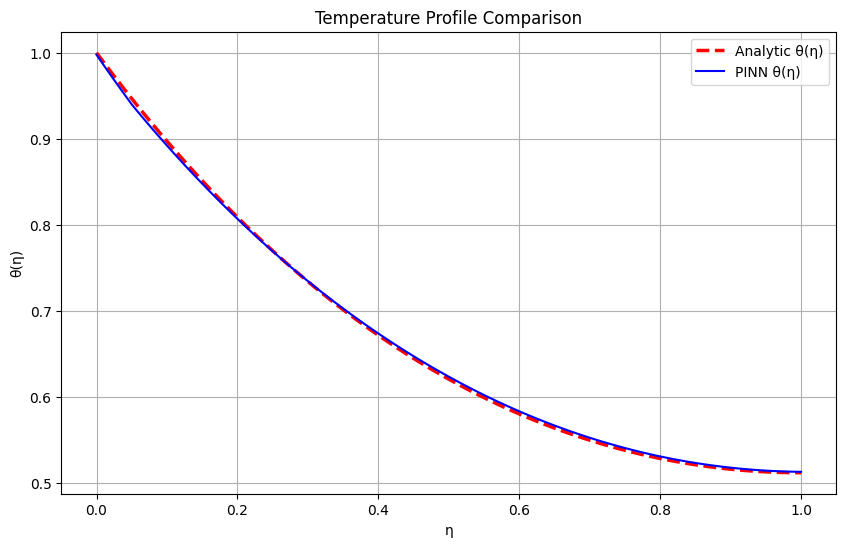

📈 RMSE of Temperature: 0.002868
📊 R² Score of Temperature: 0.999607


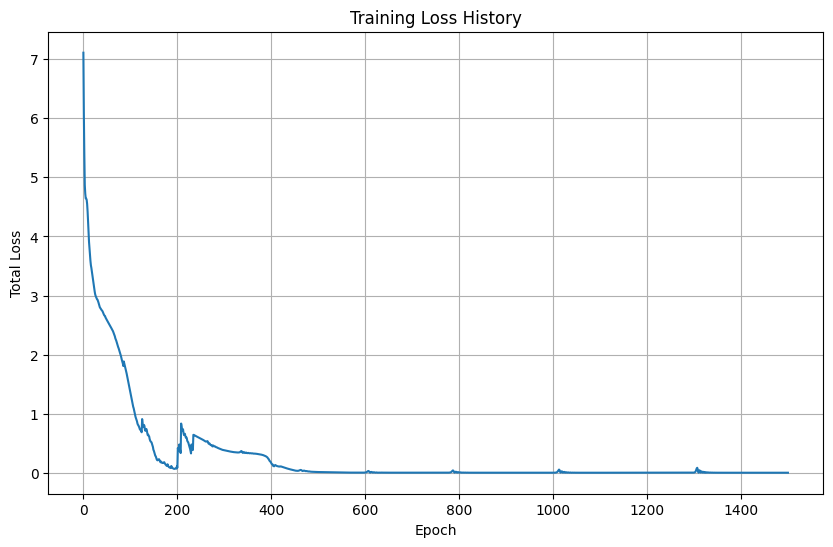

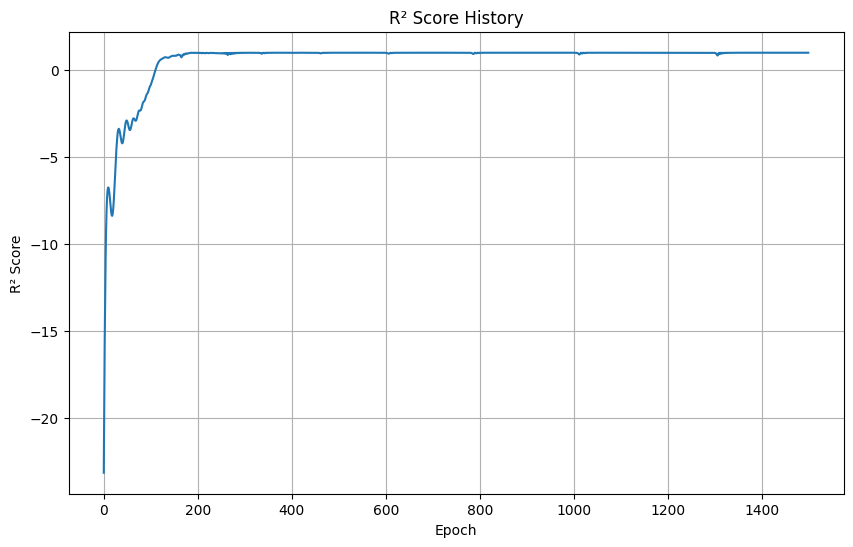

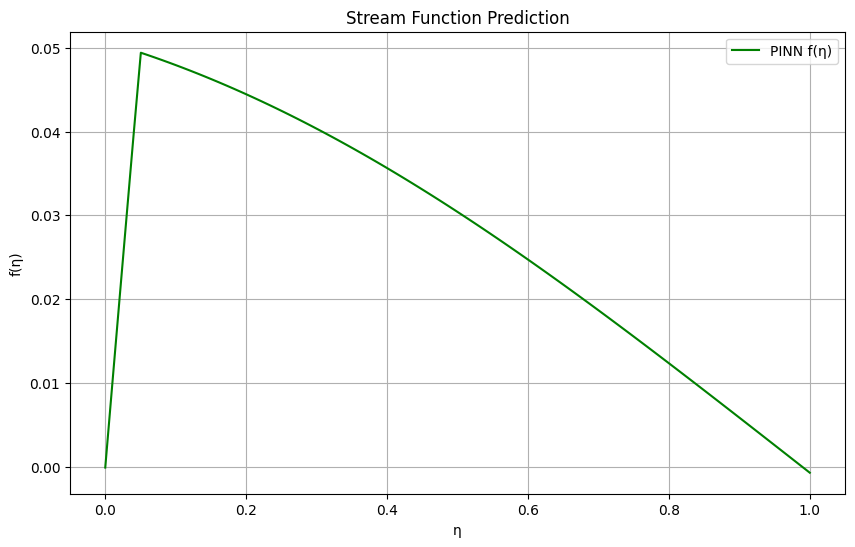

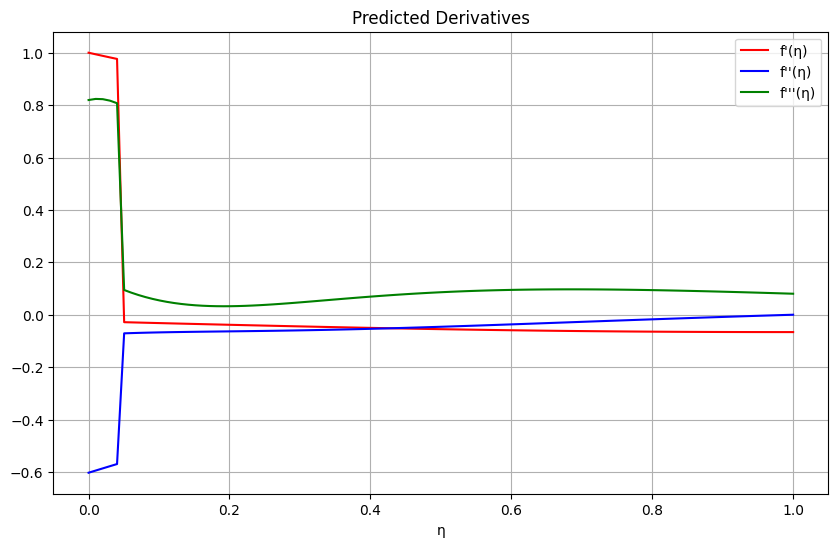

f'(0) prediction: 0.9999
f(1) prediction: -0.0007
f''(1) prediction: 0.0004
theta'(1) prediction: -0.0088


In [6]:
print("✅ Training complete!")

# 📊 Step 6: Validation & Visualization
test_eta = tf.linspace(0.0, 1.0, 100)[:, tf.newaxis]
f_pred, theta_pred = model(test_eta)

# Plotting the temperature comparison with analytical data
if not analytic_eta.numpy().size == 0:
    _, theta_pred_at_analytic = model(analytic_eta)
    plt.figure(figsize=(10, 6))
    plt.plot(analytic_eta, analytic_theta, 'r--', label='Analytic θ(η)', linewidth=2.5)
    plt.plot(analytic_eta, theta_pred_at_analytic.numpy(), 'b-', label='PINN θ(η)', linewidth=1.5)
    plt.title("Temperature Profile Comparison")
    plt.xlabel("η")
    plt.ylabel("θ(η)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Calculate and print RMSE
    rmse = np.sqrt(tf.reduce_mean(tf.square(analytic_theta - theta_pred_at_analytic)))
    print(f"📈 RMSE of Temperature: {rmse:.6f}")

    # Calculate and print R-squared
    ss_total = tf.reduce_sum(tf.square(analytic_theta - tf.reduce_mean(analytic_theta)))
    ss_residual = tf.reduce_sum(tf.square(analytic_theta - theta_pred_at_analytic))
    r2 = 1 - ss_residual / ss_total
    print(f"📊 R² Score of Temperature: {r2:.6f}")

# Plotting the training loss history
plt.figure(figsize=(10, 6))
plt.plot(range(EPOCHS), loss_history)
plt.title("Training Loss History")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.grid(True)
plt.show()

# Plotting the R-squared history
if not all(np.isnan(r2_history)): # Check if R2 data was collected
    plt.figure(figsize=(10, 6))
    plt.plot(range(EPOCHS), r2_history)
    plt.title("R² Score History")
    plt.xlabel("Epoch")
    plt.ylabel("R² Score")
    plt.grid(True)
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(test_eta, f_pred.numpy(), 'g-', label='PINN f(η)', linewidth=1.5)
plt.title("Stream Function Prediction")
plt.xlabel("η")
plt.ylabel("f(η)")
plt.legend()
plt.grid(True)
plt.show()

# You can plot the derivatives to visually check if they satisfy the boundary conditions.
with tf.GradientTape(persistent=True) as tape_derivatives:
    tape_derivatives.watch(test_eta)
    f_test, theta_test = model(test_eta)
    f1_test = tape_derivatives.gradient(f_test, test_eta)
    theta1_test = tape_derivatives.gradient(theta_test, test_eta)
    f2_test = tape_derivatives.gradient(f1_test, test_eta)
    f3_test = tape_derivatives.gradient(f2_test, test_eta)

plt.figure(figsize=(10, 6))
plt.plot(test_eta, f1_test, 'r-', label="f'(η)")
plt.plot(test_eta, f2_test, 'b-', label="f''(η)")
plt.plot(test_eta, f3_test, 'g-', label="f'''(η)")
plt.title("Predicted Derivatives")
plt.xlabel("η")
plt.legend()
plt.grid(True)
plt.show()

print(f"f'(0) prediction: {f1_test.numpy()[0][0]:.4f}")
print(f"f(1) prediction: {f_pred.numpy()[-1][0]:.4f}")
print(f"f''(1) prediction: {f2_test.numpy()[-1][0]:.4f}")
print(f"theta'(1) prediction: {theta1_test.numpy()[-1][0]:.4f}")